In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import tensorflow as tf
from itertools import chain

In [2]:
# 일단 기업 과제로 나온 데이터보다 양이 훨씬 더 많은 것을 볼 수 있음.
train = pd.read_json("./data/train.json", orient='records', encoding='utf-8-sig')
train.head()

,id,extractive,article_original
0,196524,"[13, 14, 15]","[[1] 의용 부동산등기법 제35조 제1항,, 제60조 제1항은 등기를 신청함에는 ..."
1,106984,"[1, 2, 4]",[가. 주택개량을 위하여 조합원들이 스스로 결성한 주택개량재개발조합이 실시하는 재개...
2,190919,"[1, 2, 3]","[금원의 목적 내지 성질상 국가나 지방자치단체와 특정인 사이에서만 수수,, 결제되어..."
3,110573,"[0, 2, 5]",[가. 자동차대여업자의 직원으로서는 운전면허 없는 운전자가 위조된 운전면허증의 복사...
4,156698,"[0, 2, 3]",[소외회사의 평리사 6명을 제쳐 놓고 대표이사 3명만의 결의에 의하여 동회사의 대표...


In [3]:
test = pd.read_json("./data/test.json", orient='records', encoding='utf-8-sig')
test.head()

,id,article_original
0,79095,[승객이 놓고 내린 지하철의 전동차 바닥이나 선반 위에 있던 물건을 가지고 간 경우...
1,204506,[[1] 영업비밀 보유자가 거래 상대방에게 영업비밀을 사용하도록 승낙하는 의사표시는...
2,142079,[[1] 구 상속세 및 증여세법(2010. 1. 1. 법률 제9916호로 개정되기 ...
3,110816,[가. 처분문서는 그 진정성립이 인정되는 이상 법원은 그 기재내용을 부인할 만한 분...
4,207249,"[농지개량조합이 고용원을 일정기간 채용한 뒤 해임하고, 대부분 바로 그 다음날에 다..."


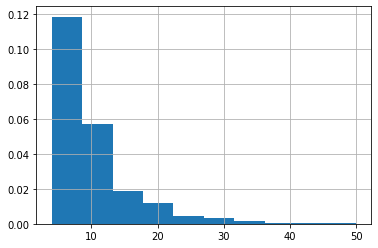

In [4]:
# article_original 문장 수 탐색
# 대다수의 article은 4 ~ 10개 사이의 문장으로 구성되어 있음
sent_cnt = train["article_original"].str.len()
sent_cnt.sort_values().hist(bins=10, density=True)

<BarContainer object of 50 artists>

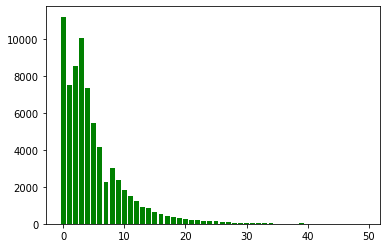

In [21]:
# extractive (정답 문항 레이블)의 위치 분포
# 정답 인덱스는 0 ~ 49 사이에 분포하고 있고, 법원 판결문이기 때문에 대체로 앞에 위치한 것을 볼 수 있음
# 반면 판결문의 내용 요약이 뒷쪽에 위치하는 경우는 거의 없고 인덱스가 40이 넘어가는 상황을 보기 힘듦.
from collections import Counter
label_cnt = []

for i in train["extractive"]:
    label_cnt += i
label_cnt = Counter(label_cnt)
plt.bar(label_cnt.keys(), label_cnt.values(),color='g')

In [6]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [7]:
sample_encoding = tokenizer.tokenize("이건 테스트 인코딩입니다", truncation=True, padding=True)
sample_encoding

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['▁이건', '▁테', '스트', '▁인', '코', '딩', '입', '니', '다']

In [8]:
# 문장 당 토큰 갯수 분포도 구하기
token_per_sent = []
for sent in range(len(train["article_original"])):
    encoding = []
    for x in range(len(train["article_original"][sent])):
        encoding.append(tokenizer.encode(train["article_original"][sent][x],truncation=True, add_special_tokens=True))
    token_per_sent.append(len(encoding))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(array([0.11871608, 0.05719109, 0.0186475 , 0.0116988 , 0.004732  ,
        0.00316673, 0.00170098, 0.00066049, 0.00057001, 0.00030762]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <a list of 10 Patch objects>)

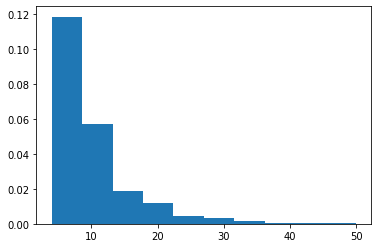

In [22]:
# 편차는 4.6개, 토큰의 평균 갯수는 약 9.57개가 분포되어 있음
plt.hist(token_per_sent, bins=10, density=True)

In [19]:
print(sum(token_per_sent)/len(token_per_sent))

9.568984891996504
